# Avaliando Modelo Gerado pelo autoML - Turing

In [1]:
%run -i '/home/.Turing/TuringCredentialsAccess.py3'
%run -i '/home/.Turing/TuringLabFunctions.py3'

------------- Turing Lab Data Science --------------------
------ Funções carregadas em memória com sucesso ---------
--------- Data da última atualização: --------------------
--------------- 20/08/2019 -------------------------------
----------------------------------------------------------
--- Consulte o manual de Biblioteca de Funções Turing: ---


----------------------------------------------------------


In [2]:
import pandas as pd
import numpy as np

## ------------------------------- Definição de Parâmetros de Projeto ------------------------------- 

In [20]:
#---------- Definição dos Parâmetros do projeto ---------------------------------
nm_bucket = 'turing-bkt-treinamentos'
id_empresa = '1022'

# Id do projeto parametrizado no Turing (o mesmo valor dado ao campo Id Projeto do Timeline)
id_projeto = '10000'

# Nome da tabela utilizada para desenvolver o modelo
nm_file_desenv_orig = 'ABT01_TITANIC_DESENV.csv'

# Nome da tabela utilizada para validar o modelo (out-of-time ou out-of-sample)
nm_file_valida_orig = 'OOS01_TITANIC_VALID.csv'

nm_file_desenv = 'SCORE_DESENV_' + id_projeto + '.csv'
nm_file_valida = 'SCORE_VALIDA_' + id_projeto + '.csv'

# Nome da variável resposta (quando houve)
targetname = 'Survived'

# Delimitador da tabela 
abt_delimiter = ','

#### Gerando credenciais de acessos ao projeto

In [21]:
################### Não alterar este parágrafo #####################################
#---------- Gerando Credenciais para Acesso Seguro ---------------------------------
id_modelo = id_projeto
schema = 'EMP_'+ id_empresa +'_Proj_'+ id_projeto
S3fs,S3session,S3client,S3resource = TuringUsersCredentialsControl(id_empresa)
schema_rds = 'EMP_'+id_empresa+'_Proj_'+id_projeto
mysq_conn,engine = TuringRDSManagementConn(id_empresa,schema_rds,turing_adm = 'N')
path_s3_wfile = 's3://'+nm_bucket+'/Projetos/'+'Projeto_'+id_projeto+'/Modelo_Id_'+id_projeto+'/Modeltrain/'
s3_path = path_s3_wfile
####################################################################################

Acesso RDS Turing Treinamentos


#### Leitura da tabela de desenvolvimento do modelo

In [22]:
# Lendo tabela de desenvolvimento original do bucket da POC
path_file = 'Projetos/FLAT_TABLES/'+str(nm_file_desenv_orig)
desenv_df = TuringReadS3CSVFile(nm_bucket,path_file,sep=abt_delimiter)
desenv_df.shape

(623, 12)

In [23]:
desenv_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S,1
1,53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C,1
2,387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S,0
3,125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S,0
4,579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C,0


#### Leitura da tabela desenvolvimento (holdout) escorada pelo Turing 

In [24]:
# Lendo tabela de desenvolvimento original do bucket da POC
nm_file_desenv_holdout = 'scored_best_model_desenv.csv'
path_ = 'Projetos/'+'Projeto_'+id_projeto+'/Modelo_Id_'+id_projeto+'/Modeltrain/'
path_file = path_+str(nm_file_desenv_holdout)
desenv_df_ho = TuringReadS3CSVFile(nm_bucket,path_file,sep=abt_delimiter)

desenv_df_ho.rename( columns={'Unnamed: 0':'Id'}, inplace=True )
desenv_df_ho.shape

(694, 10)

In [25]:
desenv_df_ho.head()

,Id,Fare,Age,Pclass,TGD_Sex_female,TGD_Sex_male,P_Target_0,P_Target_1,C_Target,target_t_bin
0,793,-0.030371,0.000000,-1.566107,0,1,0.499778,0.500221,1,0
1,678,0.295895,1.023561,0.827377,1,0,0.526193,0.473807,0,0
2,368,-0.492378,0.000000,0.827377,1,0,0.474178,0.525822,1,1
3,569,-0.490280,0.177063,0.827377,0,1,0.538327,0.461673,0,1
4,443,-0.386671,-0.130754,-0.369365,1,0,0.459541,0.540459,1,1


#### Leitura da tabela de desenvolvimento escorada

In [26]:
path_file = 'Projetos/'+'Projeto_'+id_projeto+'/Modelo_Id_'+id_projeto+'/Modeltrain/' + 'abt_score_tbin.parquet'
desenv_score = TuringReadParquetFile(S3fs,nm_bucket,path_file)
desenv_score.shape

(891, 10)

#### Leitura da tabela de validação do modelo
    - Podendo ser out-of-time ou out-of-sample
 

In [27]:
# Lendo tabela de desenvolvimento original do bucket da POC
path_file = 'Projetos/SCORE_BATCH/'+str(nm_file_valida_orig)
valida_df = TuringReadS3CSVFile(nm_bucket,path_file,sep=abt_delimiter)
valida_df.shape

(268, 12)

In [28]:
desenv_score.head()

,PassengerId,Fare,Age,Pclass,TGD_Sex_female,TGD_Sex_male,P_Target_0,P_Target_1,C_Target,target_t_bin
0,1,-0.502445,-0.592481,0.827377,0,1,0.538327,0.461673,0,0
1,2,0.786845,0.638789,-1.566107,1,0,0.459541,0.540459,1,1
2,3,-0.488854,-0.284663,0.827377,1,0,0.494383,0.505617,1,1
3,4,0.420730,0.407926,-1.566107,1,0,0.459541,0.540459,1,1
4,5,-0.486337,0.407926,0.827377,0,1,0.538327,0.461673,0,0


#### Leitura da tabela de validação escorada pelo Turing
    - Esta tabela pode ser gerada pelo autoML - Turing (Timeline Escoragem Batch)
    - Esta tabela pode ser gerada pelo processo manual (Turing Lab Data Science - Score Batch)
    - Nomenclatura padrão S_<nome tabela validaçao>_AAAAMMDD.csv

In [32]:
# Lendo tabela escorada pelo Turing

nome_arq_batch_escorado = 'S_OOS01_TITANIC_VALID_20190820.csv'

path_file = 'Projetos/'+'Projeto_'+id_projeto+'/Modelo_Id_'+id_projeto+'/Modelscoring/'+nome_arq_batch_escorado

valida_score = TuringReadS3CSVFile(nm_bucket,path_file,sep=abt_delimiter)
valida_score.shape

(268, 11)

In [33]:
valida_score.head()

,Fare,Age,Pclass,TGD_Sex_female,TGD_Sex_male,P_Target_0,P_Target_1,C_Target,PassengerId,PK_DATREF_XX,PK_DATVER_XX
0,-0.357308,0.000000,0.827377,0,1,0.538327,0.461673,0,496,20190820,2019-08-20 18:25:53
1,-0.496405,0.000000,0.827377,0,1,0.538327,0.461673,0,649,20190820,2019-08-20 18:25:53
2,-0.061999,-1.746796,0.827377,0,1,0.528955,0.471045,0,279,20190820,2019-08-20 18:25:53
3,2.301729,0.000000,-1.566107,1,0,0.459541,0.540459,1,32,20190820,2019-08-20 18:25:53
4,-0.341452,-0.053800,0.827377,1,0,0.494383,0.505617,1,256,20190820,2019-08-20 18:25:53


## 2 - Ajustando a Tabela de Validação Escorada

### Merge da tabela de validação escorada e original

In [34]:
valida_score_final = pd.merge(valida_score[['PassengerId','P_Target_0','P_Target_1']], valida_df[['PassengerId',targetname]], on = ['PassengerId'], how = 'left')
valida_score_final.shape

(268, 4)

In [35]:
valida_score_final.head()

,PassengerId,P_Target_0,P_Target_1,Survived
0,496,0.538327,0.461673,0
1,649,0.538327,0.461673,0
2,279,0.528955,0.471045,0
3,32,0.459541,0.540459,1
4,256,0.494383,0.505617,1


###  Salvando tabelas escoradas para consumo

#### Tabela de desenvolvimento

In [36]:
s3_path_desenv = 'turing-bkt-treinamentos/Projetos/SCORED_TABLES/'
nm_s3_file = 'SCORE_DESENV_'+id_projeto+'.csv'
TuringWriteS3CSVFile(desenv_score,s3_path_desenv,nm_s3_file,S3fs,delimiter=',')

encoding=latin-1


'Arquivo Salvo Com Sucesso'

#### Tabela de Validação

In [37]:
s3_path_desenv = 'turing-bkt-treinamentos/Projetos/SCORED_TABLES/'
nm_s3_file = 'SCORE_VALID_'+id_projeto+'.csv'
TuringWriteS3CSVFile(valida_score_final,s3_path_desenv,nm_s3_file,S3fs,delimiter=',')

encoding=latin-1


'Arquivo Salvo Com Sucesso'

## ------------------------------- Métricas de Desempenho ------------------------------- 

## 1- Cálculo do KS:

### 1.1 Obtendo o KS para a Tabela de Desenvolvimento

In [38]:
KS_df,KS_value = TuringEvaluateModels(desenv_score,'P_Target_0','target_t_bin')
KS_df.head(10)

,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.459541,0.467616,170,9,179,0.05,94.97%,48.07,
1,0.474178,0.494383,78,43,121,0.55,64.46%,63.04,
2,0.499569,0.499779,30,34,64,1.13,46.88%,65.62,<== KS ==
3,0.500897,0.526193,22,71,93,3.23,23.66%,59.12,
4,0.528751,0.538327,42,392,434,9.33,9.68%,0.00,


### 1.2 Obtendo o KS para a Tabela de Validação

In [39]:
KS_df,KS_value = TuringEvaluateModels(valida_score_final,'P_Target_0',targetname)
KS_df.head(10)

,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.459541,0.474178,56,4,60,0.07,93.33%,53.62,
1,0.478932,0.494383,18,15,33,0.83,54.55%,62.69,
2,0.499569,0.499778,10,8,18,0.80,55.56%,67.93,<== KS ==
3,0.503277,0.526193,7,18,25,2.57,28.00%,64.21,
4,0.528751,0.538327,9,123,132,13.67,6.82%,-0.00,


## 2- Cálculo do Gini:

### 2.1 Obtendo o Gini para a Tabela de Desenvolvimento

In [40]:
from sklearn.metrics import roc_curve, auc

y = desenv_score.target_t_bin
y_pred = desenv_score.P_Target_1

false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
roc_auc = round(auc(false_positive_rate, true_positive_rate), 4)
gini = round((2*roc_auc - 1), 4)
gini

0.7634

### 2.2 Obtendo o Gini para a Tabela de Validação

In [41]:
from sklearn.metrics import roc_curve, auc

y = valida_score_final.Survived
y_pred = valida_score_final.P_Target_1

false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
roc_auc = round(auc(false_positive_rate, true_positive_rate), 4)
gini = round((2*roc_auc - 1), 4)
gini

0.801

## ------------------------------- Métricas de Desempenho por Safra ------------------------------- 
Somente quando o modelo foi desenvolvido considerando histórico safrado

## 1- Cálculo do KS por Safras:

### 1.1- Agrupando por SAFRA - Validação

In [22]:
var_safra = 'safra'
var_id = 'id'

In [23]:
safra_aux = valida_score_final.groupby([var_safra]).count().reset_index()
vetor_safra = safra_aux[var_safra].values

ks_array = []
for safra in vetor_safra:
    
    KS_df,KS_value = TuringEvaluateModels(valida_score_final[valida_score_final[var_safra]==safra],'P_Target_0',targetname)
    ks_array.append(KS_value)

KeyError: 'safra'

In [43]:
ks_safra_df = pd.DataFrame(data=ks_array, columns=['KS'])
vetor_safra_df = pd.DataFrame(data=vetor_safra, columns=['SAFRA'])
ks_safra_valida = vetor_safra_df.merge(ks_safra_df, left_index=True, right_index=True, how = 'inner')
ks_safra_valida.head(12)

,SAFRA,KS
0,201702,6.53
1,201703,6.51
2,201704,5.90
3,201705,3.14
4,201706,9.95
5,201707,4.09


### 1.2- Merge da tabela de desenvolvimento escorada e original

In [47]:
# Trazendo o 'TARGET' da tabela original para a escorada
desenv_target_df = pd.merge(desenv_score[[var_id,var_safra,'P_Target_0','P_Target_1']], desenv_df[[var_id,targetname]], on = [var_id], how = 'left')
desenv_target_df.shape

(25710, 5)

In [48]:
desenv_target_df.head()

,id,cd_posicao,P_Target_0,P_Target_1,over60m6
0,9001,201609,0.708150,0.291850,0
1,9009,201501,0.934703,0.065297,0
2,9010,201501,0.927962,0.072038,0
3,9011,201501,0.393950,0.606050,1
4,9015,201510,0.933913,0.066087,0


### 1.3- Agrupando por SAFRA - Desenvolvimento

In [49]:
safra_aux = desenv_target_df.groupby([var_safra]).count().reset_index()
vetor_safra = safra_aux[var_safra].values

ks_array = []
for safra in vetor_safra:
    
    KS_df,KS_value = TuringEvaluateModels(desenv_target_df[desenv_target_df[var_safra]==safra],'P_Target_0',targetname)
    ks_array.append(KS_value)

In [50]:
ks_safra_df = pd.DataFrame(data=ks_array, columns=['KS'])
vetor_safra_df = pd.DataFrame(data=vetor_safra, columns=['SAFRA'])
ks_safra_desenv = vetor_safra_df.merge(ks_safra_df, left_index=True, right_index=True, how = 'inner').sort_values(['SAFRA'] , ascending = True )
ks_safra_desenv.head(10)

,SAFRA,KS
0,201403,39.04
1,201408,32.45
2,201410,34.18
3,201501,36.48
4,201503,34.29
5,201505,29.89
6,201506,40.23
7,201507,43.26
8,201508,29.84
9,201509,34.94


### 1.4- Agrupando as tabelas

In [52]:
# Juntando as duas tabelas
ks_safra_desenv['SAFRA'] = ks_safra_desenv[['SAFRA']].astype(str)
ks_safra_valida['SAFRA'] = ks_safra_valida[['SAFRA']].astype(str)

ks_full = ks_safra_desenv.append(ks_safra_valida, ignore_index=True)
ks_full.head(24)

,SAFRA,KS
0,201403,39.04
1,201408,32.45
2,201410,34.18
3,201501,36.48
4,201503,34.29
5,201505,29.89
6,201506,40.23
7,201507,43.26
8,201508,29.84
9,201509,34.94


### 1.5- Plotando KS por Safra

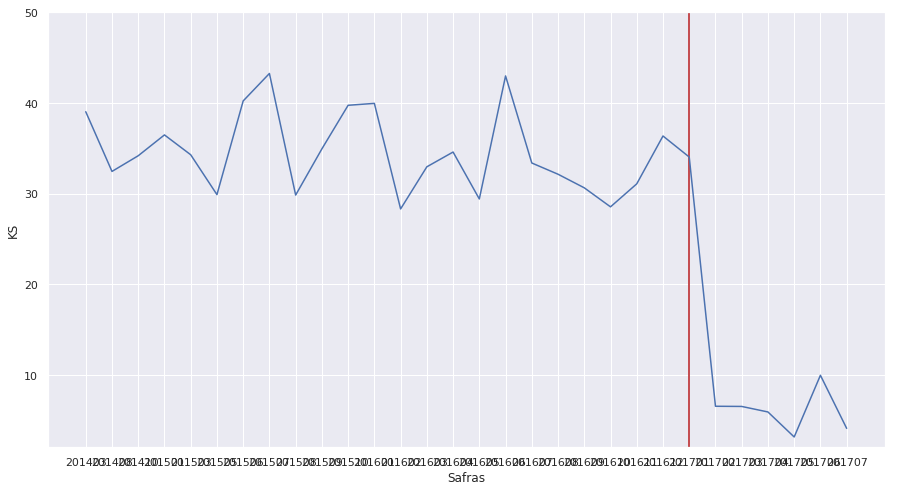

In [54]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
#fmri = sns.load_dataset("ks_safra")
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="SAFRA", y="KS", data=ks_full)
ax.set(ylim=(2, 50))
ax.set(xlabel='Safras', ylabel='KS')
ax.vlines(ks_safra_desenv.iloc[ks_safra_desenv.shape[0]-1,0] , 0, 80, lw=2, color='r')

## 2- Cálculo do Gini por Safras:

### 2.1- Agrupando por SAFRA - Validação

In [56]:
safra_aux = valida_score_final.groupby([var_safra]).count().reset_index()
vetor_safra = safra_aux[var_safra].values

gini_array = []
for safra in vetor_safra:
  
    df_aux = valida_score_final[valida_score_final[var_safra]==safra]
    y = df_aux.target_t_bin
    y_pred = df_aux.P_Target_1
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    roc_auc = round(auc(false_positive_rate, true_positive_rate), 4)
    gini = round((2*roc_auc - 1), 4)
    gini_array.append(gini)

In [57]:
gini_safra_df = pd.DataFrame(data=gini_array, columns=['GINI'])*100
vetor_safra_df = pd.DataFrame(data=vetor_safra, columns=['SAFRA'])
gini_safra_valida = vetor_safra_df.merge(gini_safra_df, left_index=True, right_index=True, how = 'inner')
gini_safra_valida = gini_safra_valida
gini_safra_valida.head()

,SAFRA,GINI
0,201702,3.76
1,201703,6.18
2,201704,1.74
3,201705,2.42
4,201706,6.28


### 2.2- Agrupando por SAFRA - Desenvolvimento

In [59]:
safra_aux = desenv_target_df.groupby([var_safra]).count().reset_index()
vetor_safra = safra_aux[var_safra].values

gini_array = []
for safra in vetor_safra:
    
    df_aux = desenv_target_df[desenv_target_df[var_safra]==safra]
    y = df_aux.target_t_bin
    y_pred = df_aux.P_Target_1
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    roc_auc = round(auc(false_positive_rate, true_positive_rate), 4)
    gini = round((2*roc_auc - 1), 4)
    gini_array.append(gini)

In [60]:
gini_safra_df = pd.DataFrame(data=gini_array, columns=['GINI'])*100
vetor_safra_df = pd.DataFrame(data=vetor_safra, columns=['SAFRA'])
gini_safra_desenv = vetor_safra_df.merge(gini_safra_df, left_index=True, right_index=True, how = 'inner')
gini_safra_desenv = gini_safra_desenv
gini_safra_desenv

,SAFRA,GINI
0,201403,47.36
1,201408,46.32
2,201410,46.74
3,201501,45.74
4,201503,45.94
5,201505,42.16
6,201506,54.26
7,201507,54.72
8,201508,38.34
9,201509,41.24


### 2.3- Agrupando as tabelas

In [62]:
gini_safra_desenv['SAFRA'] = gini_safra_desenv[['SAFRA']].astype(str)
gini_safra_valida['SAFRA'] = gini_safra_valida[['SAFRA']].astype(str)

gini_full = gini_safra_desenv.append(gini_safra_valida, ignore_index=True)
gini_full.head(30)

,SAFRA,GINI
0,201403,47.36
1,201408,46.32
2,201410,46.74
3,201501,45.74
4,201503,45.94
5,201505,42.16
6,201506,54.26
7,201507,54.72
8,201508,38.34
9,201509,41.24


### 2.4- Plotando Gini por Safra

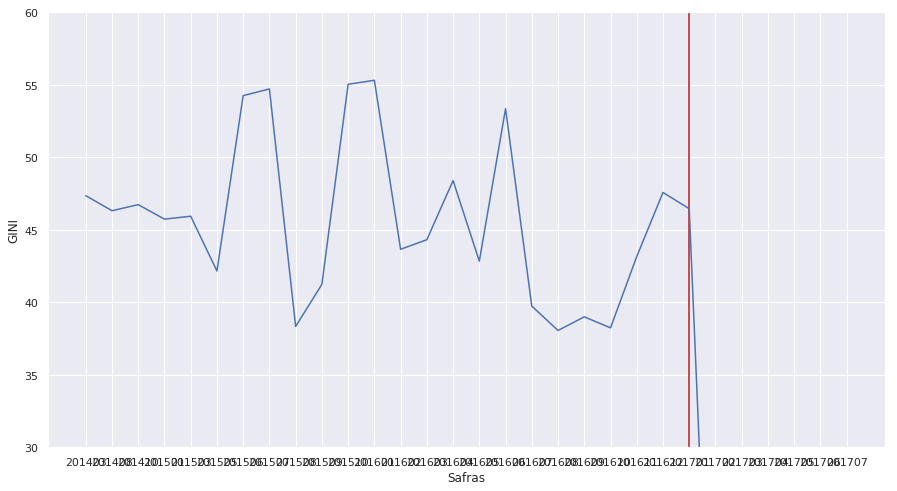

In [63]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
ax = sns.lineplot(x="SAFRA", y="GINI", data=gini_full)
ax.set(ylim=(30, 60))
ax.set(xlabel='Safras', ylabel='GINI')
ax.vlines(gini_safra_desenv.iloc[gini_safra_desenv.shape[0]-1,0], 0, 100, lw=2, color='r')